In [1]:
# importing all the required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV 
import pyLDAvis.sklearn

D:\Anaconda\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
biden_dataframe=pd.read_csv("biden_speech.csv")
trump_dataframe=pd.read_csv("trump_speech.csv")

In [3]:
biden_dataframe=biden_dataframe[pd.notna(biden_dataframe.text)].reset_index(drop=True)
trump_dataframe=trump_dataframe[pd.notna(trump_dataframe.text)].reset_index(drop=True)

In [4]:
appos = {
"aren't" : "are not","can't" : "cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not","don't" : "do not",
"hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "I would","i'd" : "I had",
"i'll" : "I will","i'm" : "I am","isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us",
"mightn't" : "might not","mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will",
"she's" : "she is","shouldn't" : "should not","that's" : "that is","there's" : "there is","they'd" : "they would","they'll" : "they will",
"they're" : "they are","they've" : "they have","we'd" : "we would","we're" : "we are","weren't" : "were not","we've" : "we have",
"what'll" : "what will","what're" : "what are",
"what's" : "what is","what've" : "what have","where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is",
"who've" : "who have","won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will",
"you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not","we'll":" will","didn't": "did not"}

In [5]:
def clean_data(temp_data):
    """
    Function to clean the data
    
    Input: String Type
    Output: String Type
    
    """
    temp_data=temp_data.lower()
    temp_data=temp_data.split(" ")
    temp=[]
    for i in temp_data:
        if i in appos.keys():
            temp.extend(appos[i].split(" "))
        else:
            temp.append(i)
    temp_data=" ".join(temp)
    
    pattern = re.compile("r'\([^)]*\)'")
    temp_data = pattern.sub(" ", temp_data)
    
    temp_data=temp_data.replace('\n'," ").replace("\r"," ") #removes \n,\r

    temp_data=re.sub('[\W\_]',' ',temp_data) #removes special characters

    temp_data=re.sub(r'\d+', '',temp_data) #removes digits

    tokens=word_tokenize(temp_data) #tokenizes the words

    stopwords=nltk.corpus.stopwords.words("english")
    
    lemmatizer=WordNetLemmatizer()
    
    tokens=[lemmatizer.lemmatize(i) for i in tokens if ((i not in stopwords) & (len(i)>2))] # Lemmatizes the word from third person to first person
    return " ".join(tokens)

In [6]:
biden_dataframe["clean_text"]=biden_dataframe.text.apply(clean_data)
trump_dataframe["clean_text"]=trump_dataframe.text.apply(clean_data)

In [113]:
def display_topics(model, feature_names, no_top_words):
    """
    Function to print the top specified number of topics 
    It does not give us directly what is the topic but it 
    gives us the top words that can help us to guess the topic
    
    Input:
    model- lda model
    feature names - the features i.e the words in our case
    no_top_words: The number of top words to print
    
    Output:
    Prints the topics and the top words that can help us to 
    guess the topics
    
    """
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        #print(*sorted(topic)[::-1][:no_top_words])

In [184]:
tf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.1, stop_words='english')
tf = tf_vectorizer.fit_transform(biden_dataframe.clean_text) #fits and transforms the data giving us a sparse matrix which 
                                                                 #have the weights of the words 

tf_feature_names = tf_vectorizer.get_feature_names()   

In [185]:
#We apply lda to our output from tfidf vectorizer to get the top 10 most important topics
lda = LatentDirichletAllocation(n_components=5, max_iter=100, learning_method='online',random_state=0,n_jobs=-1)
lda_z = lda.fit_transform(tf)

In [186]:
#5 0.8 0.1
display_topics(lda, tf_feature_names, no_top_words=10)

Topic 0:
mask vote wearing save nation virus month job talked justice
Topic 1:
vote nation job kamala black school tell trump counted hard
Topic 2:
trump job donald virus unemployment pandemic crosstalk victory number economy
Topic 3:
nation virus division trump quote testing mask end believe lost
Topic 4:
trump job vote nation folk donald school sure lot tax


In [187]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))

# See model parameters
print(lda.get_params())

Log Likelihood:  -6143.058291714267
Perplexity:  7651.157900418029
{'max_iter': 100, 'verbose': 0, 'learning_method': 'online', 'mean_change_tol': 0.001, 'n_topics': None, 'doc_topic_prior': None, 'n_components': 5, 'evaluate_every': -1, 'perp_tol': 0.1, 'learning_offset': 10.0, 'total_samples': 1000000.0, 'topic_word_prior': None, 'n_jobs': -1, 'learning_decay': 0.7, 'random_state': 0, 'batch_size': 128, 'max_doc_update_iter': 100}


In [188]:
# Define Search Param
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=100, learning_method='online',random_state=0,n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [189]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'n_components': 5, 'learning_decay': 0.7}
Best Log Likelihood Score:  -2348.6330379590113
Model Perplexity:  7651.123943065843


In [190]:
display_topics(best_lda_model, tf_feature_names, no_top_words=10)

Topic 0:
mask vote job wearing senate justice talked nation pennsylvania mayor
Topic 1:
trump job vote nation folk donald school sure lot tax
Topic 2:
trump job donald virus pandemic economy existing unemployment coming courage
Topic 3:
virus trump quote division testing mask end march nation person
Topic 4:
tax billion count vote school trump sure senator nation business


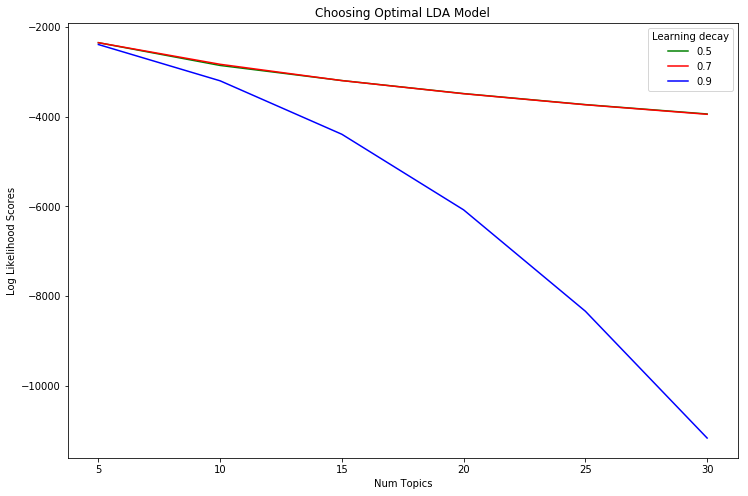

In [191]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5',color="g")
plt.plot(n_topics, log_likelyhoods_7, label='0.7',color="r")
plt.plot(n_topics, log_likelyhoods_9, label='0.9',color="b")
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [192]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model=best_lda_model, dtm=tf, vectorizer=tf_vectorizer,mds="tsne")

D:\Anaconda\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [193]:
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x          y
topic                                                   
1      95.196915        1       1  194.997726 -70.119171
4       1.200772        1       2  271.919373 -61.477688
0       1.200772        1       3  177.960541  32.864529
2       1.200771        1       4  128.657059 -30.236107
3       1.200770        1       5  253.371124  16.423244, topic_info=     Category      Freq         Term     Total  loglift  logprob
term                                                            
841   Default  2.000000       nation  2.000000  30.0000  30.0000
1402  Default  2.000000         vote  2.000000  29.0000  29.0000
508   Default  1.000000         folk  1.000000  28.0000  28.0000
378   Default  1.000000       donald  1.000000  27.0000  27.0000
691   Default  2.000000          job  2.000000  26.0000  26.0000
1356  Default  2.000000        trump  2.000000  25.0000  25.0000
1140  Default  1.000000       school  1.000000  24.0000  24.0000
1283  Default  1.000000         sure  1.000000  23.0000  23.0000
776   Default  1.000000          lot  1.000000  22.0000  22.0000
1300  Default  1.000000          tax  1.000000  21.0000  21.0000
152   Default  1.000000     business  1.000000  20.0000  20.0000
794   Default  1.000000         mask  1.000000  19.0000  19.0000
922   Default  1.000000          pay  1.000000  18.0000  18.0000
831   Default  1.000000        month  1.000000  17.0000  17.0000
1398  Default  1.000000        virus  1.000000  16.0000  16.0000
905   Default  1.000000     pandemic  1.000000  15.0000  15.0000
1047  Default  1.000000       really  1.000000  14.0000  14.0000
700   Default  1.000000      justice  1.000000  13.0000  13.0000
787   Default  1.000000       making  1.000000  12.0000  12.0000
111   Default  1.000000      billion  1.000000  11.0000  11.0000
627   Default  1.000000         home  1.000000  10.0000  10.0000
1308  Default  1.000000         tell  1.000000   9.0000   9.0000
1455  Default  1.000000       worker  1.000000   8.0000   8.0000
183   Default  1.000000       change  1.000000   7.0000   7.0000
865   Default  1.000000       number  1.000000   6.0000   6.0000
775   Default  1.000000         lost  1.000000   5.0000   5.0000
592   Default  1.000000         hard  1.000000   4.0000   4.0000
830   Default  1.000000        money  1.000000   3.0000   3.0000
145   Default  1.000000        build  1.000000   2.0000   2.0000
579   Default  1.000000          guy  1.000000   1.0000   1.0000
...       ...       ...          ...       ...      ...      ...
1398   Topic5  0.005624        virus  1.375699  -1.0776  -7.2908
1356   Topic5  0.005623        trump  2.993882  -1.8553  -7.2910
1029   Topic5  0.005620        quote  0.912635  -0.6677  -7.2914
373    Topic5  0.005619     division  0.747712  -0.4686  -7.2916
1317   Topic5  0.005619      testing  0.918233  -0.6740  -7.2916
794    Topic5  0.005618         mask  1.438831  -1.1233  -7.2917
417    Topic5  0.005618          end  0.990475  -0.7499  -7.2918
791    Topic5  0.005618        march  0.411532   0.1283  -7.2918
841    Topic5  0.005618       nation  2.284908  -1.5859  -7.2918
932    Topic5  0.005618       person  0.773552  -0.5028  -7.2918
917    Topic5  0.005618         past  0.529546  -0.1239  -7.2919
830    Topic5  0.005618        money  1.168893  -0.9157  -7.2919
113    Topic5  0.005618          bit  0.415524   0.1186  -7.2919
21     Topic5  0.005617   affordable  0.854812  -0.6028  -7.2919
775    Topic5  0.005617         lost  1.209725  -0.9501  -7.2920
1237   Topic5  0.005617    statement  0.445514   0.0488  -7.2920
339    Topic5  0.005617  desperately  0.282856   0.5031  -7.2920
984    Topic5  0.005617        price  0.565545  -0.1898  -7.2920
366    Topic5  0.005617   distancing  0.430360   0.0834  -7.2920
1176   Topic5  0.005617        short  0.464575   0.0069  -7.2920
1094   Topic5  0.005617     response  0.565930  -0.1905  -7.2920
647    Topic5  0.005617      imagine  0.650873  

# TRUMP

In [194]:
tf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.1, stop_words='english')
tf = tf_vectorizer.fit_transform(list(trump_dataframe.clean_text.values)) #fits and transforms the data giving us a sparse matrix which 
                                                                 #have the weights of the words 

tf_feature_names = tf_vectorizer.get_feature_names()   

In [195]:
#We apply lda to our output from tfidf vectorizer to get the top 10 most important topics
lda = LatentDirichletAllocation(n_components=5, max_iter=100, learning_method='online',random_state=0,n_jobs=-1)
lda_z = lda.fit_transform(tf)

In [196]:
display_topics(lda, tf_feature_names, no_top_words=10)

Topic 0:
peace upfront type wedding senior walked isi comey largely developed
Topic 1:
biden vote joe election america win michigan law inaudible money
Topic 2:
august medal declaration extreme california brave relationship flying member seven
Topic 3:
biden vote america win joe love guy nation mean new
Topic 4:
biden drug georgia love test especially voting medicine money final


In [197]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))

# See model parameters
print(lda.get_params())

Log Likelihood:  -6988.336361696827
Perplexity:  9674.724477947428
{'max_iter': 100, 'verbose': 0, 'learning_method': 'online', 'mean_change_tol': 0.001, 'n_topics': None, 'doc_topic_prior': None, 'n_components': 5, 'evaluate_every': -1, 'perp_tol': 0.1, 'learning_offset': 10.0, 'total_samples': 1000000.0, 'topic_word_prior': None, 'n_jobs': -1, 'learning_decay': 0.7, 'random_state': 0, 'batch_size': 128, 'max_doc_update_iter': 100}


In [198]:
# Define Search Param
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=100, learning_method='online',random_state=0,n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [199]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'n_components': 5, 'learning_decay': 0.7}
Best Log Likelihood Score:  -2689.770239985034
Model Perplexity:  9674.724477947428


In [202]:
display_topics(best_lda_model, tf_feature_names, no_top_words=10)

Topic 0:
peace upfront type wedding senior walked isi comey largely developed
Topic 1:
biden vote joe election america win michigan law inaudible money
Topic 2:
august medal declaration extreme california brave relationship flying member seven
Topic 3:
biden vote america win joe love guy nation mean new
Topic 4:
biden drug georgia love test especially voting medicine money final


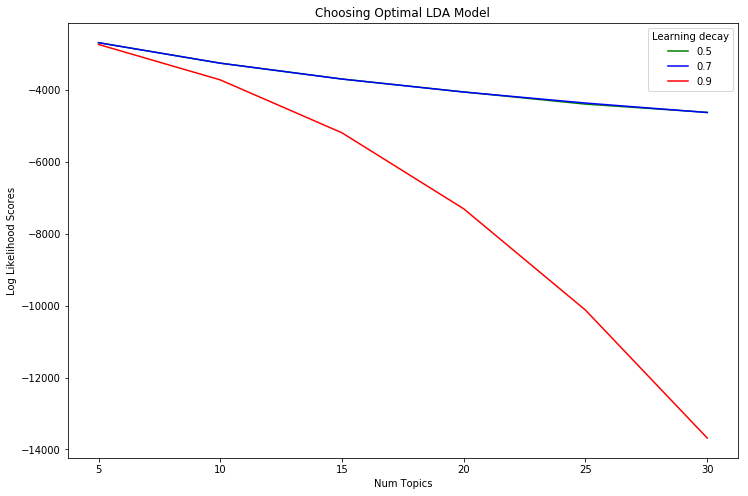

In [203]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5',color="g")
plt.plot(n_topics, log_likelyhoods_7, label='0.7',color="b")
plt.plot(n_topics, log_likelyhoods_9, label='0.9',color="r")
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [177]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model=best_lda_model, dtm=tf, vectorizer=tf_vectorizer,mds="tsne")

D:\Anaconda\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [178]:
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
3      95.368610        1       1   57.810604   49.916809
1       1.157849        1       2  295.177063   61.211475
4       1.157848        1       3   56.258743 -270.561432
2       1.157847        1       4 -123.861946 -103.250481
0       1.157846        1       5  276.797394 -183.934586, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
61    Default  2.000000         america  2.000000  30.0000  30.0000
1811  Default  1.000000             win  1.000000  29.0000  29.0000
856   Default  1.000000             joe  1.000000  28.0000  28.0000
967   Default  1.000000            love  1.000000  27.0000  27.0000
702   Default  1.000000             guy  1.000000  26.0000  26.0000
1766  Default  2.000000            vote  2.000000  25.0000  25.0000
1063  Default  1.000000          nation  1.000000  24.0000  24.0000
1000  Default  1.000000            mean  1.000000  23.0000  23.0000
1081  Default  1.000000             new  1.000000  22.0000  22.0000
1745  Default  1.000000         vaccine  1.000000  21.0000  21.0000
452   Default  1.000000            drug  1.000000  20.0000  20.0000
119   Default  1.000000          ballot  1.000000  19.0000  19.0000
1672  Default  1.000000           today  1.000000  18.0000  18.0000
474   Default  1.000000        election  1.000000  17.0000  17.0000
1250  Default  1.000000         problem  1.000000  16.0000  16.0000
115   Default  1.000000             bad  1.000000  15.0000  15.0000
1649  Default  1.000000            test  1.000000  14.0000  14.0000
398   Default  1.000000        democrat  1.000000  13.0000  13.0000
709   Default  1.000000          happen  1.000000  12.0000  12.0000
146   Default  3.000000           biden  3.000000  11.0000  11.0000
920   Default  1.000000            left  1.000000  10.0000  10.0000
1708  Default  1.000000           trump  1.000000   9.0000   9.0000
1164  Default  1.000000    pennsylvania  1.000000   8.0000   8.0000
197   Default  1.000000            came  1.000000   7.0000   7.0000
1189  Default  1.000000           place  1.000000   6.0000   6.0000
1628  Default  1.000000             tax  1.000000   5.0000   5.0000
680   Default  1.000000        governor  1.000000   4.0000   4.0000
704   Default  1.000000            half  1.000000   3.0000   3.0000
1803  Default  1.000000            went  1.000000   2.0000   2.0000
1824  Default  1.000000           woman  1.000000   1.0000   1.0000
...       ...       ...             ...       ...      ...      ...
1718   Topic5  0.004767            type  0.231120   0.5774  -7.5227
1065   Topic5  0.004763      nationwide  0.215144   0.6482  -7.5235
1800   Topic5  0.004766         wedding  0.228675   0.5878  -7.5229
1160   Topic5  0.004768           peace  0.795466  -0.6584  -7.5225
1738   Topic5  0.004768         upfront  0.246428   0.5134  -7.5225
1447   Topic5  0.004766          senior  0.781000  -0.6405  -7.5229
1776   Topic5  0.004766          walked  0.262267   0.4507  -7.5229
840    Topic5  0.004766             isi  0.508916  -0.2122  -7.5230
280    Topic5  0.004766           comey  0.274196   0.4062  -7.5230
897    Topic5  0.004765         largely  0.278562   0.3903  -7.5231
410    Topic5  0.004765       developed  0.254845   0.4793  -7.5231
980    Topic5  0.004765          making  0.595974  -0.3703  -7.5231
794    Topic5  0.004765     impeachment  0.233473   0.5669  -7.5231
1063   Topic5  0.004765          nation  1.590263  -1.3517  -7.5231
385    Topic5  0.004765        defeated  0.282853   0.3750  -7.5231
519    Topic5  0.004765        exciting  0.453155  -0.0963  -7.5231
1739   Topic5  0.004765             usa  0.785977  -0.6470  -7.5231
765    Topic5  0.004765        horribly  0.299862   0.3165  -7.5232
166    Topic5  0.004765             bos  0.286055   0.3637  -7.5232
124    Topic5  

In [7]:
economic_policy=["economy", "growth", "new","business", "income", "wage"]
woman_and_voters= ["woman", "election", "president","future", "young"]
immigration=["immigration", "illegal", "law","border", "criminal", "visa"]
climate_change=["energy", "climate", "clean","renewable"]
pandemic=["pandemic","virus","mask","vaccine","coronavirus","corona","covid"]

In [8]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [9]:
def total_policy_words(word_list):
    total=[]
    for i in range(len(temp)):
        k=0
        for j in word_list:
            if j in temp[i].keys():
                k+=temp[i][j]
        total.append(k)
    return total

In [10]:
temp=trump_dataframe.clean_text.apply(word_count) 

In [11]:
trump_dataframe["economic_policy"]=total_policy_words(economic_policy)
trump_dataframe["woman_and_voters"]=total_policy_words(woman_and_voters)
trump_dataframe["climate_change"]=total_policy_words(climate_change)
trump_dataframe["immigration"]=total_policy_words(immigration)
trump_dataframe["pandemic"]=total_policy_words(pandemic)

In [12]:
temp=biden_dataframe.clean_text.apply(word_count) 

In [13]:
biden_dataframe["economic_policy"]=total_policy_words(economic_policy)
biden_dataframe["woman_and_voters"]=total_policy_words(woman_and_voters)
biden_dataframe["climate_change"]=total_policy_words(climate_change)
biden_dataframe["immigration"]=total_policy_words(immigration)
biden_dataframe["pandemic"]=total_policy_words(pandemic)

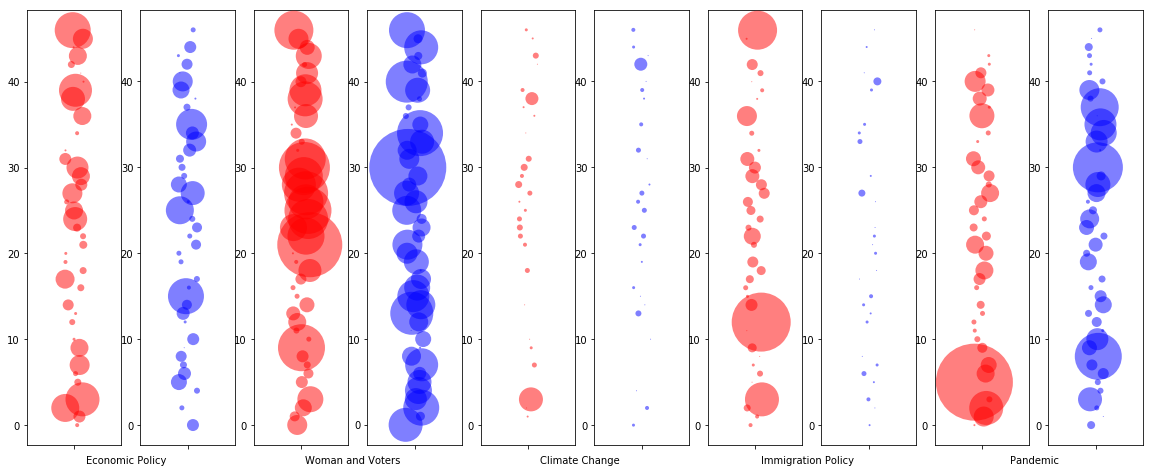

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns 
#Save the image
fig, axs = plt.subplots(1, 10,figsize=(20,8)) 
#horizontal strip plot 
trump_plot = sns.stripplot(x = np.arange(47),size=trump_dataframe["economic_policy"].values , color="red",orient="v",edgecolor="black",ax=axs[0],alpha=.5)
axs[0].set_xlabel("Economic Policy")
axs[0].xaxis.set_label_coords(1.05, -0.025)
trump_plot = sns.stripplot(x = np.arange(47) ,size=trump_dataframe["woman_and_voters"].values , color="red",orient="v",edgecolor="black",ax=axs[2],alpha=.5)
axs[2].set_xlabel("Woman and Voters")
axs[2].xaxis.set_label_coords(1.05, -0.025)
trump_plot = sns.stripplot(x = np.arange(47) ,size=trump_dataframe["climate_change"].values , color="red",orient="v",edgecolor="black",ax=axs[4],alpha=.5)
axs[4].set_xlabel("Climate Change")
axs[4].xaxis.set_label_coords(1.05, -0.025)
trump_plot = sns.stripplot(x = np.arange(47) ,size=trump_dataframe["immigration"].values , color="red",orient="v",edgecolor="black",ax=axs[6],alpha=.5)
axs[6].set_xlabel("Immigration Policy")
axs[6].xaxis.set_label_coords(1.05, -0.025)
trump_plot = sns.stripplot(x = np.arange(47) ,size=trump_dataframe["pandemic"].values , color="red",orient="v",edgecolor="black",ax=axs[8],alpha=.5)
axs[8].set_xlabel("Pandemic")
axs[8].xaxis.set_label_coords(1.05, -0.025)
biden_plot = sns.stripplot(x = np.arange(47),size=biden_dataframe["economic_policy"].values , color="blue",orient="v",edgecolor="black",ax=axs[1],alpha=.5)
biden_plot = sns.stripplot(x = np.arange(47) ,size=biden_dataframe["woman_and_voters"].values , color="blue",orient="v",edgecolor="black",ax=axs[3],alpha=.5)
biden_plot = sns.stripplot(x = np.arange(47) ,size=biden_dataframe["climate_change"].values , color="blue",orient="v",edgecolor="black",ax=axs[5],alpha=.5)
biden_plot = sns.stripplot(x = np.arange(47) ,size=biden_dataframe["immigration"].values , color="blue",orient="v",edgecolor="black",ax=axs[7],alpha=.5)
biden_plot = sns.stripplot(x = np.arange(47) ,size=biden_dataframe["pandemic"].values , color="blue",orient="v",edgecolor="black",ax=axs[9],alpha=.5)

#labels 

#plt.ylabel("Conspiracy Key Words in Tweets")
#plt.title("Conspiracy Keywords Tweeted by D") 
#save the plot
fig = trump_plot.get_figure()
fig.savefig("trump_LexicalDispersion_ex.png") 